In [1]:
import comet_ml
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
import seaborn as sns
import matplotlib.ticker as mtick
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt
import shap

In [2]:
# log model function
def log_model_params(model, name, auc_score):
    experiment = comet_ml.Experiment(
        api_key="gmAPCzUKBakTVqV4nYmrnO17S",
        project_name="xgboost",
        workspace="nhl-analytics-milestone-2"
    )
    pickle.dump(model, open("./models/xgboost_" + name + ".pkl", "wb"))
    experiment.log_model("xgboost", "./models/xgboost_" + name + ".pkl")
    experiment.log_metric("auc_score", auc_score)
    experiment.end()

In [3]:
# load data filtering out missing values (Nans) for now, although technically xgboost can handle them
data = pd.read_csv('advanced_models_data.csv')
data.dropna(inplace=True)
print(data.isna().sum())

Unnamed: 0           0
GameID               0
ShotType             0
Period               0
GameTime             0
XCoord               0
YCoord               0
isEmptyNet           0
isGoal               0
DistanceToGoal       0
ShootingAngle        0
LastEvent            0
LastEvent_XCoord     0
LastEvent_YCoord     0
TimeLastEvent        0
DistanceLastEvent    0
Rebound              0
AngleChange          0
Speed                0
dtype: int64


### XGBoost with only 2 features: "DistanceToGoal" and "ShootingAngle"

In [4]:
# Various variables
seed = 42
feature = ["DistanceToGoal","ShootingAngle"]
label = ["isGoal"]

In [5]:
# Train Val split
train, val = train_test_split(data, test_size=0.2, random_state=seed)
# adjust for shape
X1_train = train[feature].to_numpy().reshape(-1, len(feature))
y1_train = train[label].to_numpy().reshape(-1, 1)
X1_val = val[feature].to_numpy().reshape(-1, len(feature))
y1_val = val[label].to_numpy().reshape(-1, 1)
# make sure shape could be processed by xgboost
print(X1_train.shape, y1_train.shape, X1_val.shape, y1_val.shape)

(258238, 2) (258238, 1) (64560, 2) (64560, 1)


In [6]:
# first xgb model
xgb1_model = xgb.XGBClassifier(objective = "binary:logistic")
xgb1_model.fit(X1_train, y1_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [7]:
# metrics for 1st model
y1_pred = xgb1_model.predict(X1_val)
score_prob1 = xgb1_model.predict_proba(X1_val)[:,1]
auc_score1 = roc_auc_score(y1_val, score_prob1)
fpr1, tpr1, threshold = roc_curve(y1_val, score_prob1)
roc_auc1 = auc(fpr1, tpr1)
print(auc_score1)

0.7073971738993082


In [8]:
log_model_params(xgb1_model, "1st", auc_score1)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/Users/tonyzhu/文件/0_project' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/nhl-analytics-milestone-2/xgboost/1e6ecb2909f74464b1e6b24ce8627fea

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nhl-analytics-milestone-2/xgboost/1e6ecb2909f74464b1e6b24ce8627fea
COMET INFO:   Metrics:
COMET INFO:     auc_score : 0.7073971738993082
COMET INFO:   Uploads:
C

In [9]:
# random model
np.random.seed(seed)
score_prob_random = np.random.uniform(size=len(y1_val))
fpr_random, tpr_random, threshold = roc_curve(y1_val, score_prob_random)
roc_auc_random = auc(fpr_random, tpr_random)

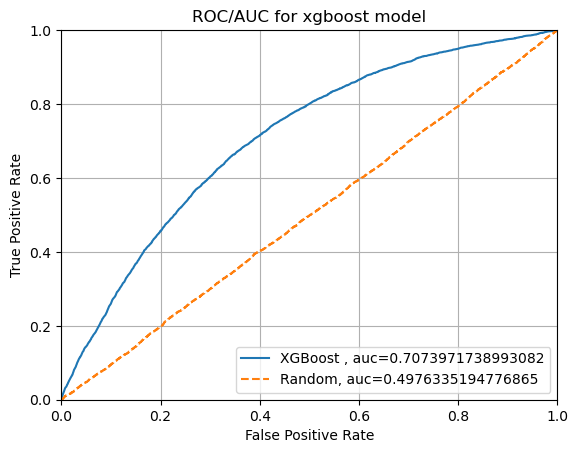

<Figure size 640x480 with 0 Axes>

In [10]:
# first curve: ROC/AUC
linestyles = ['-', '--']
names=['XGBoost', 'Random']
plt.plot(fpr1, tpr1, linestyles[0], label=names[0]+' , auc='+str(roc_auc1))
plt.plot(fpr_random, tpr_random, linestyles[1], label=names[1]+', auc='+str(roc_auc_random))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC/AUC for xgboost model')
plt.legend()
plt.grid(True)
plt.savefig('xgboost1_1.png')
plt.show()

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


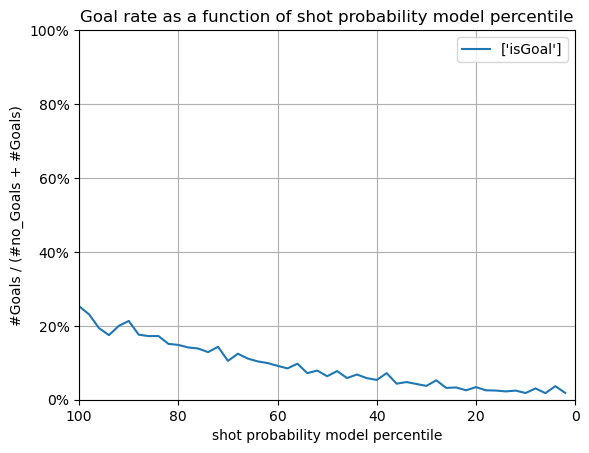

<Figure size 640x480 with 0 Axes>

In [11]:
# 2nd curve
percentile = np.arange(0, 102, 2)
pred_percentile = np.percentile(score_prob1, percentile)
pred_percentile = np.concatenate([[0], pred_percentile])
pred_percentile = np.unique(pred_percentile)
y1_val_df = pd.DataFrame(y1_val[:,0])
y1_val_df.rename(columns={ y1_val_df.columns[0]: "isGoal" }, inplace = True)
y1_val_df['percentile_bin'] = pd.cut(score_prob1, pred_percentile, include_lowest=True)
bins = np.linspace(0, 100, len(y1_val_df['percentile_bin'].unique()))[1:]
goal_rate_by_percentile_bin = y1_val_df.groupby(by=['percentile_bin']).apply(lambda f: f['isGoal'].sum()/len(f))
g = sns.lineplot(x=bins, y=goal_rate_by_percentile_bin[1:]*100, label=label)
ax = g.axes
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.xlabel('shot probability model percentile')
plt.ylabel('#Goals / (#no_Goals + #Goals)')
plt.title('Goal rate as a function of shot probability model percentile')
plt.grid(True)
plt.savefig('xgboost1_2.png')
plt.show()

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


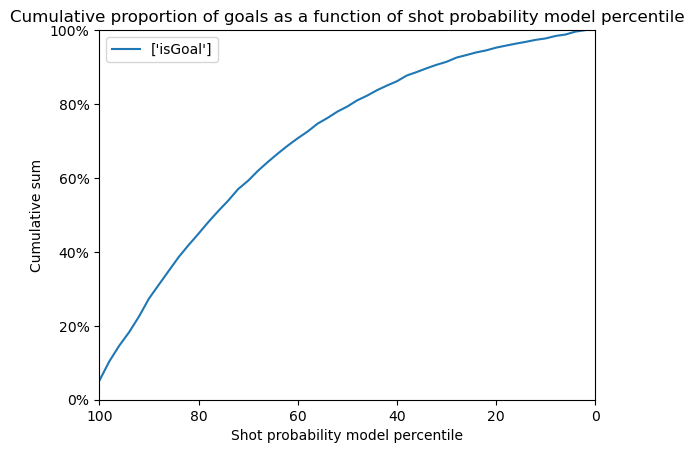

<Figure size 640x480 with 0 Axes>

In [12]:
# 3rd curve
number_goal_sum = (y1_val==1).sum()
sum_goals_by_percentile = y1_val_df.groupby(by='percentile_bin').apply(lambda f: f['isGoal'].sum()/number_goal_sum)
cumu_sum_goals = sum_goals_by_percentile[::-1].cumsum(axis=0)[::-1]
bins = np.linspace(0, 100, len(y1_val_df['percentile_bin'].unique()))[1:]

g = sns.lineplot(x=bins, y=cumu_sum_goals[1:]*100, label=label)
ax = g.axes
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
        
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.xlabel('Shot probability model percentile')
plt.ylabel('Cumulative sum')
plt.title('Cumulative proportion of goals vs probability percentile')
plt.savefig('xgboost1_3.png')
plt.show()

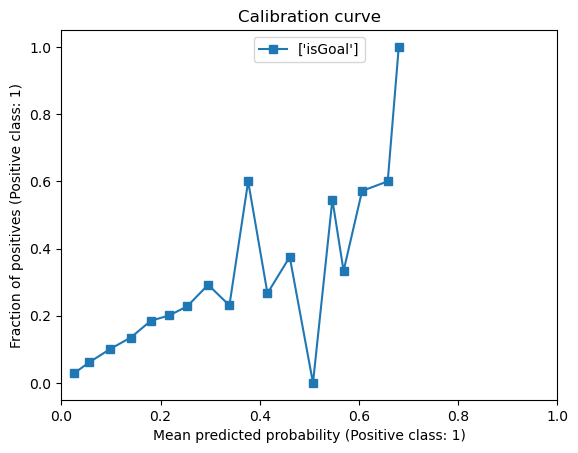

<Figure size 640x480 with 0 Axes>

In [13]:
# 4th curve
fig = plt.figure()
ax = plt.axes()
disp = CalibrationDisplay.from_predictions(y1_val, score_prob1, n_bins=25, ax=ax, name=label, ref_line=False)
plt.xlim(0, 1)
plt.legend(loc=9)
plt.title('Calibration curve')
plt.savefig('xgboost1_4.png')
plt.show()

### 2nd XGBoost with HP tuning

In [14]:
data

,Unnamed: 0,GameID,ShotType,Period,GameTime,XCoord,YCoord,isEmptyNet,isGoal,DistanceToGoal,ShootingAngle,LastEvent,LastEvent_XCoord,LastEvent_YCoord,TimeLastEvent,DistanceLastEvent,Rebound,AngleChange,Speed
0,3,2015020001,Wrist Shot,1,51.0,-55.0,6.0,0,0,35.0,-80.0,HIT,94.0,-34.0,11.0,154.0,False,0.0,14.000000
1,5,2015020001,Snap Shot,1,65.0,-79.0,0.0,0,0,10.0,0.0,GIVEAWAY,-37.0,-28.0,7.0,50.0,False,0.0,7.142857
2,6,2015020001,Snap Shot,1,66.0,-75.0,-1.0,0,0,14.0,86.0,SHOT,-79.0,0.0,1.0,4.0,True,86.0,4.000000
3,9,2015020001,Wrist Shot,1,113.0,-55.0,-36.0,0,0,50.0,43.0,HIT,-91.0,35.0,18.0,80.0,False,0.0,4.444444
4,15,2015020001,Tip-In,1,157.0,-61.0,-1.0,0,0,28.0,88.0,FACEOFF,-69.0,-22.0,5.0,22.0,False,0.0,4.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330727,1395554,2018030417,Snap Shot,3,3322.0,-77.0,7.0,0,1,14.0,-60.0,FACEOFF,0.0,0.0,0.0,77.0,False,0.0,0.000000
330728,1395556,2018030417,Snap Shot,3,3351.0,-69.0,7.0,0,0,21.0,-71.0,HIT,-68.0,-29.0,12.0,36.0,False,0.0,3.000000
330729,1395558,2018030417,Snap Shot,3,3355.0,-65.0,-4.0,0,0,24.0,81.0,FACEOFF,-69.0,-22.0,0.0,18.0,False,0.0,0.000000
330730,1395560,2018030417,Wrist Shot,3,3410.0,42.0,3.0,0,0,47.0,86.0,FACEOFF,69.0,-22.0,0.0,37.0,False,0.0,0.000000


In [15]:
# Excluding 'GameTime' and 'LastEvent' cause not relevant
X2 = data[['ShotType', 'Period', 'XCoord', 'YCoord', 'isEmptyNet',
       'DistanceToGoal', 'ShootingAngle', 'LastEvent_XCoord',
       'LastEvent_YCoord', 'TimeLastEvent', 'DistanceLastEvent', 'Rebound',
       'AngleChange', 'Speed']]
y2 = data['isGoal']

In [16]:
# encoding 'ShotType' column
onehot_E = pd.get_dummies(X2['ShotType'], prefix='ShotType')
X2 = X2.drop('ShotType', axis=1)
X2_OHE = pd.concat([X2, onehot_E], axis=1)

In [17]:
# splitting data
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_OHE, y2, test_size=0.2, random_state=seed)

In [18]:
weight= len(y2[y2 == 1])/len(y2)
weight

0.09170131165620604

In [19]:
# Tuning with GridSearch cross validation for selected hyperparameters
params2 = {
    'gamma' : [0.5, 1.0, 2.0],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}
xgb2_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', scale_pos_weight=weight)
grid_search2 = GridSearchCV(xgb2_model, params2, scoring='roc_auc', cv=3)
grid_search2.fit(X2_train, y2_train)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'gamma': [0.5, 1.0, 2.0], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc')

In [20]:
print(grid_search2.best_params_)
print(grid_search2.best_score_)

{'gamma': 0.5, 'max_depth': 7, 'n_estimators': 100}
0.9982212097591181


In [21]:
# using best HP for 2nd xgb model
xgb2_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', gamma=0.5, max_depth=7, n_estimators=100, scale_pos_weight=weight)
xgb2_model.fit(X2_train, y2_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
# metrics
y2_pred = xgb2_model.predict(X2_val)
score_prob2 = xgb2_model.predict_proba(X2_val)[:,1]
auc_score2 = roc_auc_score(y2_val, score_prob2)
fpr2, tpr2, thresholds = roc_curve(y2_val, score_prob2)
roc_auc2 = auc(fpr2, tpr2)
print(auc_score2)

0.9976863623459507


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `

In [23]:
log_model_params(xgb2_model, "2nd", auc_score2)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


COMET INFO: Couldn't find a Git repository in '/Users/tonyzhu/文件/0_project' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/nhl-analytics-milestone-2/xgboost/e2f44e2d05a944e4a6011d5c9f209777

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nhl-analytics-milestone-2/xgboost/e2f44e2d05a944e4a6011d5c9f209777
COMET INFO:   Metrics:
COMET INFO:     auc_score : 0.9976863623459507
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment

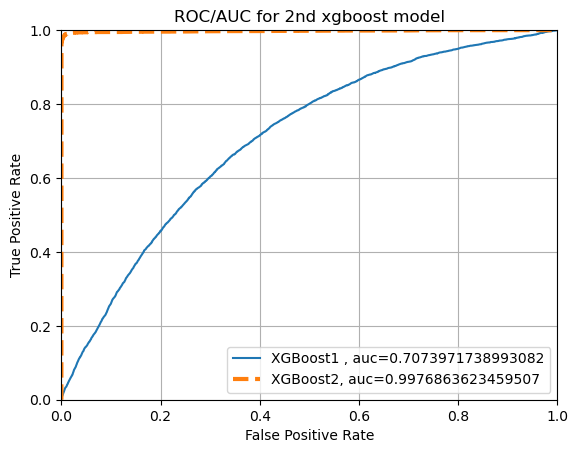

<Figure size 640x480 with 0 Axes>

In [24]:
# ROC_AUC curve for 2nd xgboost model
linestyles = ['-', '--']
names=['XGBoost1', 'XGBoost2']
plt.plot(fpr1, tpr1, linestyles[0], label=names[0]+' , auc='+str(roc_auc1))
plt.plot(fpr2, tpr2, linestyles[1], label=names[1]+', auc='+str(roc_auc2), lw=3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC/AUC for 2nd xgboost model')
plt.grid(True)
plt.savefig('xgboost2_1.png')
plt.show()

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


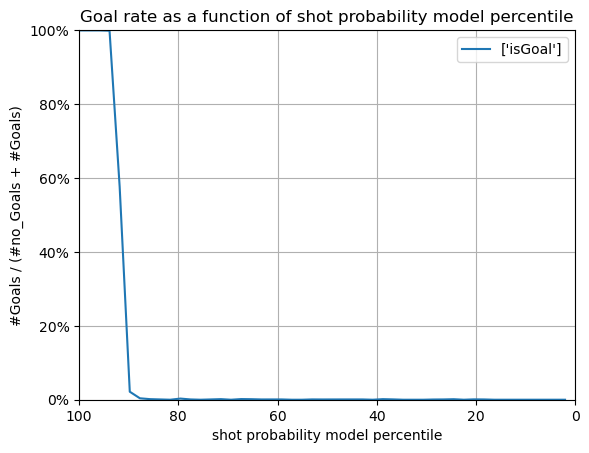

<Figure size 640x480 with 0 Axes>

In [25]:
# 2nd curve for 2nd xgboost model
percentile = np.arange(0, 102, 2)
pred_percentile = np.percentile(score_prob2, percentile)
pred_percentile = np.concatenate([[0], pred_percentile])
pred_percentile = np.unique(pred_percentile)
y2_val_df = pd.DataFrame(y2_val[:,])
y2_val_df.rename(columns={ y2_val_df.columns[0]: "isGoal" }, inplace = True)
y2_val_df['percentile_bin'] = pd.cut(score_prob2, pred_percentile, include_lowest=True)
bins = np.linspace(0, 100, len(y2_val_df['percentile_bin'].unique()))[1:]
goal_rate_by_percentile_bin = y2_val_df.groupby(by=['percentile_bin']).apply(lambda f: f['isGoal'].sum()/len(f))
g = sns.lineplot(x=bins, y=goal_rate_by_percentile_bin[1:]*100, label=label)
ax = g.axes
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.xlabel('shot probability model percentile')
plt.ylabel('#Goals / (#no_Goals + #Goals)')
plt.title('Goal rate as a function of shot probability model percentile')
plt.grid(True)
plt.savefig('xgboost2_2.png')
plt.show()

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


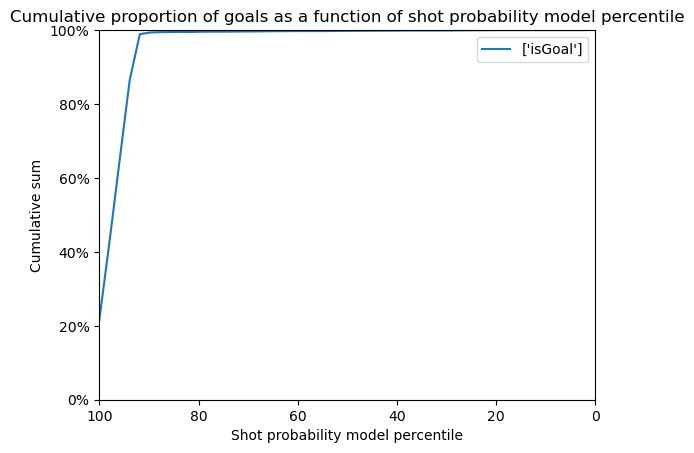

<Figure size 640x480 with 0 Axes>

In [26]:
# 3rd curve for 2nd xgboost model
number_goal_sum = (y2_val==1).sum()
sum_goals_by_percentile = y2_val_df.groupby(by='percentile_bin').apply(lambda f: f['isGoal'].sum()/number_goal_sum)
cumu_sum_goals = sum_goals_by_percentile[::-1].cumsum(axis=0)[::-1]
bins = np.linspace(0, 100, len(y2_val_df['percentile_bin'].unique()))[1:]

g = sns.lineplot(x=bins, y=cumu_sum_goals[1:]*100, label=label)
ax = g.axes
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
        
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.xlabel('Shot probability model percentile')
plt.ylabel('Cumulative sum')
plt.title('Cumulative proportion of goals vs probability percentile')
plt.savefig('xgboost2_3.png')
plt.show()

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


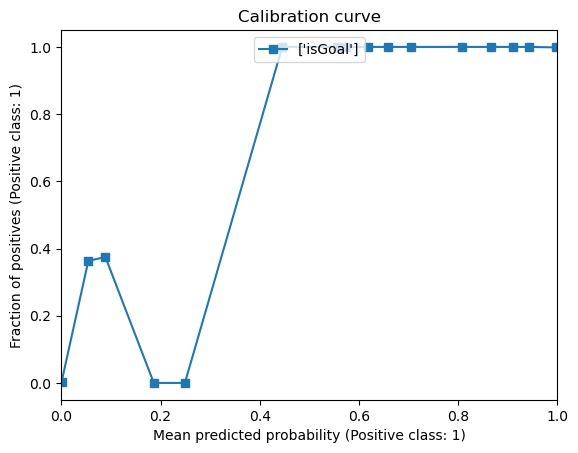

<Figure size 640x480 with 0 Axes>

In [27]:
# 4th curve for 2nd xgboost model
fig = plt.figure()
ax = plt.axes()
disp = CalibrationDisplay.from_predictions(y2_val, score_prob2, n_bins=25, ax=ax, name=label, ref_line=False)
plt.xlim(0, 1)
plt.legend(loc=9)
plt.title('Calibration curve')
plt.savefig('xgboost2_4.png')
plt.show()

### 3rd xgboost model with feature selection

For our model, since the accuracy is already 99.9%, we will simplify the model by removing some features that are not important. We will use the feature importance from the XGBoost model to determine which features to remove.

In [28]:
# feature importance from xgboost library
all_feature = X2_train.columns
dict_importance = dict(zip(all_feature, xgb2_model.feature_importances_))
sorted_dictImportance = sorted(dict_importance.items(), key=lambda item: item[1], reverse=True)
for feature, importance in sorted_dictImportance[:7]:
    print(f"Feature: {feature}, Importance: {importance}")
rSorted_importances = sorted(dict_importance.items(), key=lambda item: item[1], reverse=False)

Feature: DistanceLastEvent, Importance: 0.27386489510536194
Feature: TimeLastEvent, Importance: 0.2396830916404724
Feature: isEmptyNet, Importance: 0.11622501164674759
Feature: LastEvent_YCoord, Importance: 0.10861210525035858
Feature: Period, Importance: 0.09222791343927383
Feature: LastEvent_XCoord, Importance: 0.08315230160951614
Feature: DistanceToGoal, Importance: 0.07238943129777908


In [29]:
# SHAP verifying feature importance
explainer = shap.Explainer(xgb2_model)
shap_values = explainer.shap_values(X2_OHE)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X2_OHE.iloc[0,:])

[10:22:20] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [30]:
# keeping only the 6 most important features
X3 = X2_OHE[['DistanceLastEvent','TimeLastEvent','isEmptyNet','Period','LastEvent_YCoord', 'DistanceToGoal']]
y3 = data['isGoal']

In [31]:
X3_train,X3_val,y3_train,y3_val= train_test_split(X3,y3,test_size = 0.2,random_state = seed)

In [32]:
# HP tuning
params3 = {
    'n_estimators': [75, 100, 125],
    'max_depth': [5, 7, 9],
    'gamma': [0.5, 1.0, 1.5],
}
grid_search3 = GridSearchCV(xgb2_model, params3, scoring='roc_auc', cv=3)
grid_search3.fit(X3_train,y3_train)

print(grid_search3.best_score_)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `

0.9977050916607464


In [33]:
print(grid_search3.best_params_)

{'gamma': 1.5, 'max_depth': 7, 'n_estimators': 75}


In [34]:
# xgb3 X_train_best,X_val_best,y_train_best,y_val_best
xgb3_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', gamma=1.5, max_depth=7, n_estimators=75, scale_pos_weight=weight)
xgb3_model.fit(X3_train, y3_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=75, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [35]:
# metrics
y3_pred = xgb3_model.predict(X3_val)
score_prob3 = xgb3_model.predict_proba(X3_val)[:,1]
auc_score3 = roc_auc_score(y3_val, score_prob3)
fpr3, tpr3, thresholds = roc_curve(y3_val, score_prob3)
roc_auc3 = auc(fpr3, tpr3)
print(auc_score3)

0.9972529627714154


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `

In [36]:
log_model_params(xgb3_model, "3rd", auc_score3)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/Users/tonyzhu/文件/0_project' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/nhl-analytics-milestone-2/xgboost/9ba22c9ebf2d4c09883543cff9e2e146

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nhl-analytics-milestone-2/xgboost/9ba22c9ebf2d4c09883543cff9e2e146
COMET INFO:   Metrics:
COMET INFO:     auc_score : 0.9972529627714154
COMET INFO:   Uploads:
C

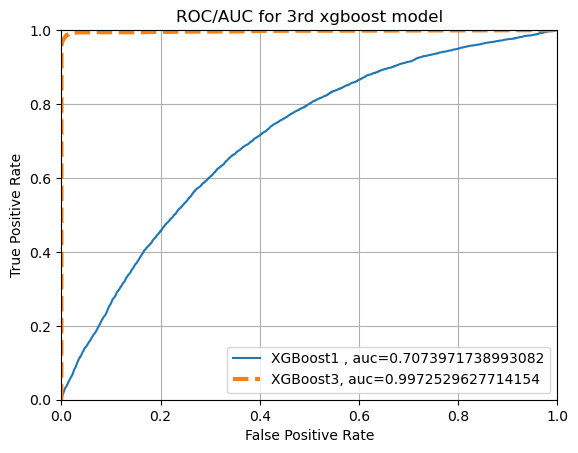

<Figure size 640x480 with 0 Axes>

In [37]:
# ROC_AUC curve for 3rd xgboost model
linestyles = ['-', '--']
names=['XGBoost1', 'XGBoost3']
plt.plot(fpr1, tpr1, linestyles[0], label=names[0]+' , auc='+str(roc_auc1))
plt.plot(fpr3, tpr3, linestyles[1], label=names[1]+', auc='+str(roc_auc3), lw=3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC/AUC for 3rd xgboost model')
plt.grid(True)
plt.savefig('xgboost3_1.png')
plt.show()

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


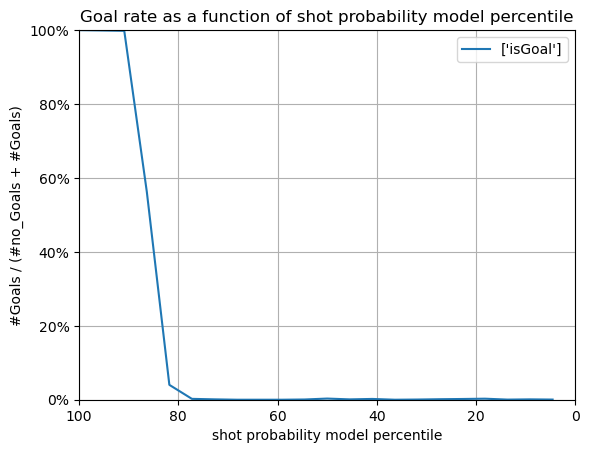

<Figure size 640x480 with 0 Axes>

In [38]:
# 2nd curve for 3rd xgboost model
percentile = np.arange(0, 102, 2)
pred_percentile = np.percentile(score_prob3, percentile)
pred_percentile = np.concatenate([[0], pred_percentile])
pred_percentile = np.unique(pred_percentile)
y3_val_df = pd.DataFrame(y3_val[:,])
y3_val_df.rename(columns={ y3_val_df.columns[0]: "isGoal" }, inplace = True)
y3_val_df['percentile_bin'] = pd.cut(score_prob3, pred_percentile, include_lowest=True)
bins = np.linspace(0, 100, len(y3_val_df['percentile_bin'].unique()))[1:]
goal_rate_by_percentile_bin = y3_val_df.groupby(by=['percentile_bin']).apply(lambda f: f['isGoal'].sum()/len(f))
g = sns.lineplot(x=bins, y=goal_rate_by_percentile_bin[1:]*100, label=label)
ax = g.axes
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.xlabel('shot probability model percentile')
plt.ylabel('#Goals / (#no_Goals + #Goals)')
plt.title('Goal rate as a function of shot probability model percentile')
plt.grid(True)
plt.savefig('xgboost3_2.png')
plt.show()

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


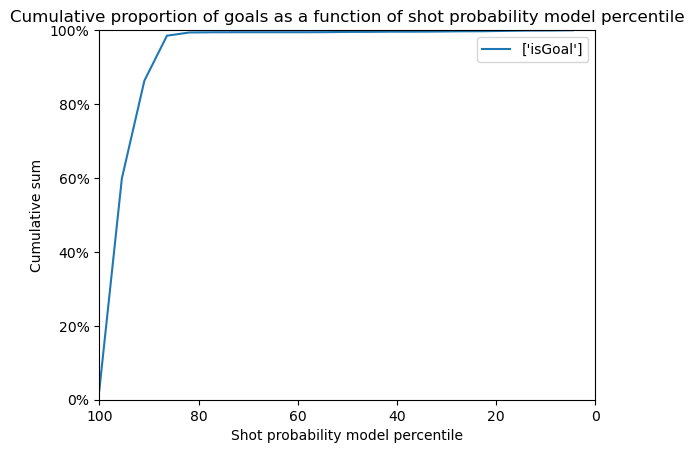

<Figure size 640x480 with 0 Axes>

In [39]:
# 3rd curve for 3rd xgboost model
number_goal_sum = (y3_val==1).sum()
sum_goals_by_percentile = y3_val_df.groupby(by='percentile_bin').apply(lambda f: f['isGoal'].sum()/number_goal_sum)
cumu_sum_goals = sum_goals_by_percentile[::-1].cumsum(axis=0)[::-1]
bins = np.linspace(0, 100, len(y3_val_df['percentile_bin'].unique()))[1:]

g = sns.lineplot(x=bins, y=cumu_sum_goals[1:]*100, label=label)
ax = g.axes
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
        
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.xlabel('Shot probability model percentile')
plt.ylabel('Cumulative sum')
plt.title('Cumulative proportion of goals vs probability percentile')
plt.savefig('xgboost3_3.png')
plt.show()

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


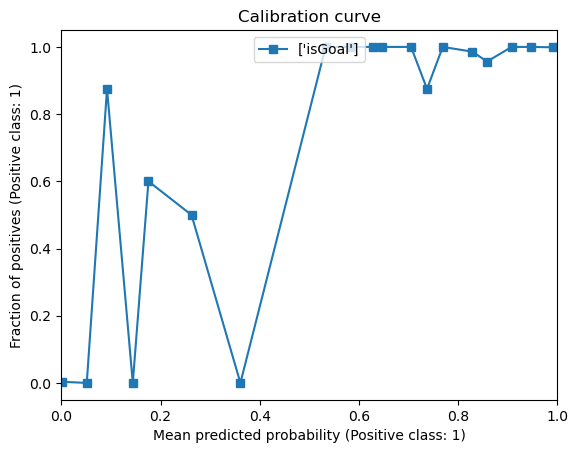

<Figure size 640x480 with 0 Axes>

In [40]:
# 4th curve for 3rd xgboost model
fig = plt.figure()
ax = plt.axes()
disp = CalibrationDisplay.from_predictions(y3_val, score_prob3, n_bins=25, ax=ax, name=label, ref_line=False)
plt.xlim(0, 1)
plt.legend(loc=9)
plt.title('Calibration curve')
plt.savefig('xgboost3_4.png')
plt.show()